# Lending Club Case Study

## Objective

The objective is to identify predictors of default so that at the time of loan application we can use those variables for approval / rejection of the loan

In [1273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Load Data

In [1274]:
loans_df = pd.read_csv("data\loan.csv")


## Studying the Data

- we are interested in data that are related to the application (eg. emp_length, income, address etc)
- we are interested in data that throw light on the characteristics of  the loan
- The data related to the customer behaviour is not interesting as we cannot make any meaningful assumption on new customers that come in on that basis

The **Target Variable** for the dataset is the loan_status which indicates the loan has defaulted or not


In [1275]:

loans_df = loans_df[[
    'application_type',
    #Indicates whether the loan is an individual application or a joint application with two co-borrowers - does having joint result worser loans ?
    'int_rate',  # Interest Rate on the loan - Does Higher Interest rates causes more defaults
    'loan_amnt',
    # The listed amount of the loan applied for by the borrower - Does the loan amount result in defaulting
    'issue_d',  #The month which the loan was funded
    'loan_status',  # is it 'Fully paid', 'Current', 'Charged-off' (defaulted)
    'verification_status',
    # Indicates if income was verified by LC - Should check if this has more incidents of defaulting
    'term',  # Does a longer 'term' have an effect on the defaulting of loans
    'grade',  # Are higher grade loans more riskier because of interest rates ?
    'sub_grade',  # LC assigned loan subgrade
    # The loan grade is the result of a formula that takes into account not only credit score,
    # but also a combination of several indicators of credit risk from the credit report and loan application.
    # All loans have either a 36- or 60-month term, with fixed interest rates and equal payments.
    # https://www.lendingclub.com/foliofn/rateDetail.action
    'dti',
    # A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
    'emp_length',
    # Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years
    'purpose',  # A category provided by the borrower for the loan request.
    'annual_inc',  # The self-reported annual income provided by the borrower during registration.
    'annual_inc_joint',  #The combined self-reported annual income provided by the co-borrowers during registration
    'revol_util',
    # Your revolving utilization rate compares your credit debt to your total credit limit, also called credit utilization or debt-to-credit ratio - lower the better
    'addr_state',  # The state provided by the borrower in the loan application
    'home_ownership'
    # The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
]]

loans_df

application_type int_rate  loan_amnt issue_d  loan_status  \
0           INDIVIDUAL   10.65%       5000  Dec-11   Fully Paid   
1           INDIVIDUAL   15.27%       2500  Dec-11  Charged Off   
2           INDIVIDUAL   15.96%       2400  Dec-11   Fully Paid   
3           INDIVIDUAL   13.49%      10000  Dec-11   Fully Paid   
4           INDIVIDUAL   12.69%       3000  Dec-11      Current   
...                ...      ...        ...     ...          ...   
39712       INDIVIDUAL    8.07%       2500  Jul-07   Fully Paid   
39713       INDIVIDUAL   10.28%       8500  Jul-07   Fully Paid   
39714       INDIVIDUAL    8.07%       5000  Jul-07   Fully Paid   
39715       INDIVIDUAL    7.43%       5000  Jul-07   Fully Paid   
39716       INDIVIDUAL   13.75%       7500  Jun-07   Fully Paid   

      verification_status        term grade sub_grade    dti emp_length  \
0                Verified   36 months     B        B2  27.65  10+ years   
1         Source Verified   60 months     C        C4   1.00   < 1 year   
2            Not Verified   36 months     C        C5   8.72  10+ years   
3         Source Verified   36 months     C        C1  20.00  10+ years   
4         Source Verified   60 months     B        B5  17.94     1 year   
...                   ...         ...   ...       ...    ...        ...   
39712        Not Verified   36 months     A        A4  11.33    4 years   
39713        Not Verified   36 months     C        C1   6.40    3 years   
39714        Not Verified   36 months     A        A4   2.30   < 1 year   
39715        Not Verified   36 months     A        A2   3.72   < 1 year   
39716        Not Verified   36 months     E        E2  14.29   < 1 year   

                  purpose  annual_inc  annual_inc_joint revol_util addr_state  \
0             credit_card     24000.0               NaN     83.70%         AZ   
1                     car     30000.0               NaN      9.40%         GA   
2          small_business     12252.0               NaN     98.50%         IL   
3                   other     49200.0               NaN        21%         CA   
4                   other     80000.0               NaN     53.90%         OR   
...                   ...         ...               ...        ...        ...   
39712    home_improvement    110000.0               NaN     13.10%         CO   
39713         credit_card     18000.0               NaN     26.90%         NC   
39714  debt_consolidation    100000.0               NaN     19.40%         MA   
39715               other    200000.0               NaN      0.70%         MD   
39716  debt_consolidation     22000.0               NaN     51.50%         MA   

      home_ownership  
0               RENT  
1               RENT  
2               RENT  
3               RENT  
4               RENT  
...              ...  
39712       MORTGAGE  
39713           RENT  
39714       MORTGAGE  
39715       MORTGAGE  
39716            OWN  

[39717 rows x 17 columns]

## Cleaning the Data

In [1276]:
# Check shape of dataset
total_rows = loans_df.shape[0]
print("# Rows: {} \n# Columns: {}".format(total_rows, loans_df.shape[1]))

# Check how many INDIVIDUAL Accounts
individual_rows = loans_df[loans_df['application_type'] == 'INDIVIDUAL'].shape[0]
print("All records have application_type INDIVIDUAL: {}".format(individual_rows == total_rows))

# dropping application type and columns for joint accounts
loans_df.drop(loans_df.application_type.name, axis=1, inplace=True)
loans_df.drop(loans_df.annual_inc_joint.name, axis=1, inplace=True)


# Rows: 39717 
# Columns: 17
All records have application_type INDIVIDUAL: True


In [1277]:
# Clean columns datatype
loans_df.info()
# int_rate remove %, precision 2, float64
# annual inc convert to int64
# issue_d create year and month column
# emp_length convert to int64 and fill missing values
# revol_util remove %, precision 2, float64 and fill missing values

loans_df['int_rate'] = loans_df.int_rate.apply(lambda x: float(str(x).replace("%", "")))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   int_rate             39717 non-null  object 
 1   loan_amnt            39717 non-null  int64  
 2   issue_d              39717 non-null  object 
 3   loan_status          39717 non-null  object 
 4   verification_status  39717 non-null  object 
 5   term                 39717 non-null  object 
 6   grade                39717 non-null  object 
 7   sub_grade            39717 non-null  object 
 8   dti                  39717 non-null  float64
 9   emp_length           38642 non-null  object 
 10  purpose              39717 non-null  object 
 11  annual_inc           39717 non-null  float64
 12  revol_util           39667 non-null  object 
 13  addr_state           39717 non-null  object 
 14  home_ownership       39717 non-null  object 
dtypes: float64(2), int64(1), object(12)


In [1278]:
# Extract the month and year from issue date
loans_df['issue_year'] = pd.DatetimeIndex(pd.to_datetime(loans_df.issue_d, format='%b-%y')).year
loans_df['issue_month'] = pd.DatetimeIndex(pd.to_datetime(loans_df.issue_d, format='%b-%y')).month

In [1279]:
# clean and fill missing values for emp_length
total_records = loans_df.shape[0]
missin_emp_length = loans_df[loans_df['emp_length'].isnull()].shape[0]
print(" {:0.2f}% missing emp_length".format((missin_emp_length / total_records) * 100))


def formatEmp_length(data):
    return str(data).replace("+ years", "").replace(" year", "").replace("< ", "").replace("s", "").replace("nan", "-1")


loans_df['emp_length'] = loans_df.emp_length.apply(lambda x: formatEmp_length(x))
loans_df['emp_length'] = loans_df['emp_length'].astype(int)
loans_df['emp_length'].describe()
#mean   4.927160
#median 4.000000
# Imputation using median
loans_df['emp_length'] = loans_df.emp_length.apply(lambda x: 4.0 if x == -1 else x)
loans_df['emp_length'].describe()

# convert annual income to int
loans_df['annual_inc'] = loans_df.annual_inc.astype(int)

 2.71% missing emp_length


In [1280]:
# revol_util remove %, precision 2, float64
loans_df['revol_util'] = loans_df.revol_util.apply(lambda x: float(str(x).replace("%", "")))
loans_df['revol_util'] = loans_df.revol_util.apply(lambda x: -1 if pd.isna(x) else x)
missin_revol_util = loans_df[loans_df['revol_util'] == -1].shape[0]
print(" {:0.2f}% missing revol_util".format((missin_revol_util / total_records) * 100))
#mean,48.832616
#mdian,49.200000
# Imputation using median
loans_df['revol_util'] = loans_df.revol_util.apply(lambda x: 49.200000 if x == -1 else x)


 0.13% missing revol_util


In [1281]:

# total rows with one null value
print("total rows with at least one null value: {}".format(loans_df.isnull().any(axis=1).sum()))


total rows with at least one null value: 0


The data we are interested in are :
    - loan_status = 'Fully Paid'
    - loan_status = 'Charged Off' (Defaulted)

These will isolate the records we need to do the analysis between understanding good and bad loans when the user registers for a loan

Outliers can be selected as the maximum and minimum whiskers of box plots on the interest rate and loan amount on both these categories

The variables with `loan_status ='Current'` can be ignored as they are current loans in progress and no meaningful information can be extracted from these


In [1282]:
current_loan_rows = loans_df[loans_df['loan_status'] == 'Current'].shape[0]
print("Dropping {} current loan rows".format(current_loan_rows))
print("Current Shape {}".format(loans_df.shape))
loans_df = loans_df.drop(loans_df[loans_df['loan_status'] == 'Current'].index)
loans_df.reset_index()
print("New Shape {}".format(loans_df.shape))

Dropping 1140 current loan rows
Current Shape (39717, 17)
New Shape (38577, 17)


### Encoding Categorical Values

In [1283]:
# Understanding categorical data
loans_df.loan_status.value_counts()  # two types - target variables

loans_df.term.value_counts()  # two types

loans_df.grade.value_counts()  # A-G 7 types
loans_df.sub_grade.value_counts()  # 1-5 / 7*5 = 35 types

loans_df.verification_status.value_counts()  # three types
loans_df.purpose.value_counts()  # 14 types
loans_df.home_ownership.value_counts()  # 5 types
loans_df.addr_state.value_counts()  # 50 states


# Understanding continuous  data
                                # count mean min 25  50   75   max
loans_df.int_rate.describe()    # 37869,11.9,5.4,8.9,11.7,14.3,24.4
loans_df.loan_amnt.describe()   # 37869,11047,500,5300,9600,15000,35000
loans_df.dti.describe()         # 37869,13.2,0,8.13,13.3,18.56,29.9
loans_df.emp_length.describe()  # 37869,5.0,1,2,4,9,10
loans_df.revol_util.describe()  # 37869,48,0,25.3,49.1,72.2,99.9
loans_df.annual_inc.describe()  # 37869,6765.3,4000,4000,57960,80000,6000000 -  check for outliers!!!

loans_df['loan_status_cat'] = loans_df['loan_status'].astype('category').cat.codes

### Removing Outliers

Default Loan IR IQR: 5.09 
Completed Loan IR IQR: 5.5 
Default Loan Loan Amount IQR: 10900.0 
Completed Loan Loan Amount IQR: 9800.0 
Outlier Default Loans InterestRate   :  5.42 < InterestRate < 23.91
Outlier Completed Loans InterestRate :  5.42 < InterestRate < 22.11
Outlier Default Loans Amount :          900 < LoansAmount < 32400
Outlier Completed Loans Amount :        500 < LoansAmount < 29700


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


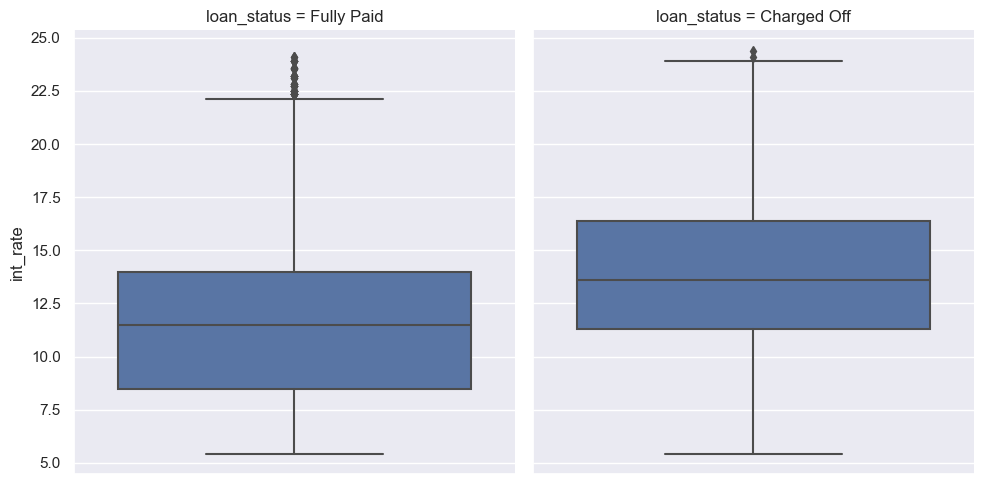

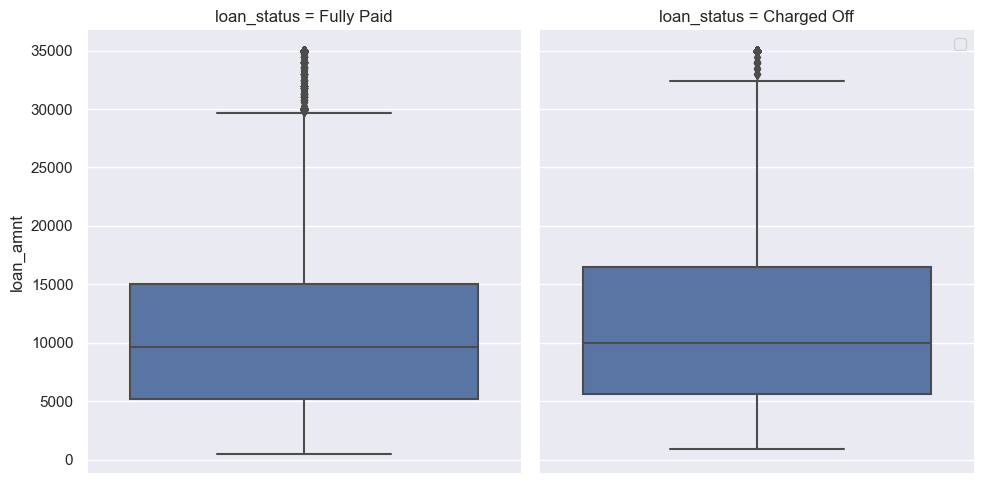

In [1284]:
sns.set(style="darkgrid")
from matplotlib.cbook import boxplot_stats

defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]
box_stats_ir_defaulted_loans = boxplot_stats(defaulted_loans.int_rate).pop(0)
box_stats_ir_completed_loans = boxplot_stats(completedLoans.int_rate).pop(0)
box_stats_la_defaulted_loans = boxplot_stats(defaulted_loans.loan_amnt).pop(0)
box_stats_la_completed_loans = boxplot_stats(completedLoans.loan_amnt).pop(0)

print("Default Loan IR IQR: {} ".format(box_stats_ir_defaulted_loans['iqr']))
print("Completed Loan IR IQR: {} ".format(box_stats_ir_completed_loans['iqr']))
print("Default Loan Loan Amount IQR: {} ".format(box_stats_la_defaulted_loans['iqr']))
print("Completed Loan Loan Amount IQR: {} ".format(box_stats_la_completed_loans['iqr']))

print("Outlier Default Loans InterestRate   :  {} < InterestRate < {}".format(box_stats_ir_defaulted_loans['whislo'],
                                                                              box_stats_ir_defaulted_loans['whishi']))
print("Outlier Completed Loans InterestRate :  {} < InterestRate < {}".format(box_stats_ir_completed_loans['whislo'],
                                                                              box_stats_ir_completed_loans['whishi']))
print("Outlier Default Loans Amount :          {} < LoansAmount < {}".format(box_stats_la_defaulted_loans['whislo'],
                                                                             box_stats_la_defaulted_loans['whishi']))
print("Outlier Completed Loans Amount :        {} < LoansAmount < {}".format(box_stats_la_completed_loans['whislo'],
                                                                             box_stats_la_completed_loans['whishi']))

sns.catplot(data=loans_df, y="int_rate", col='loan_status', hue='loan_status', kind='box');
sns.catplot(data=loans_df, y="loan_amnt", col='loan_status', hue='loan_status', kind='box');
plt.legend()
plt.show()

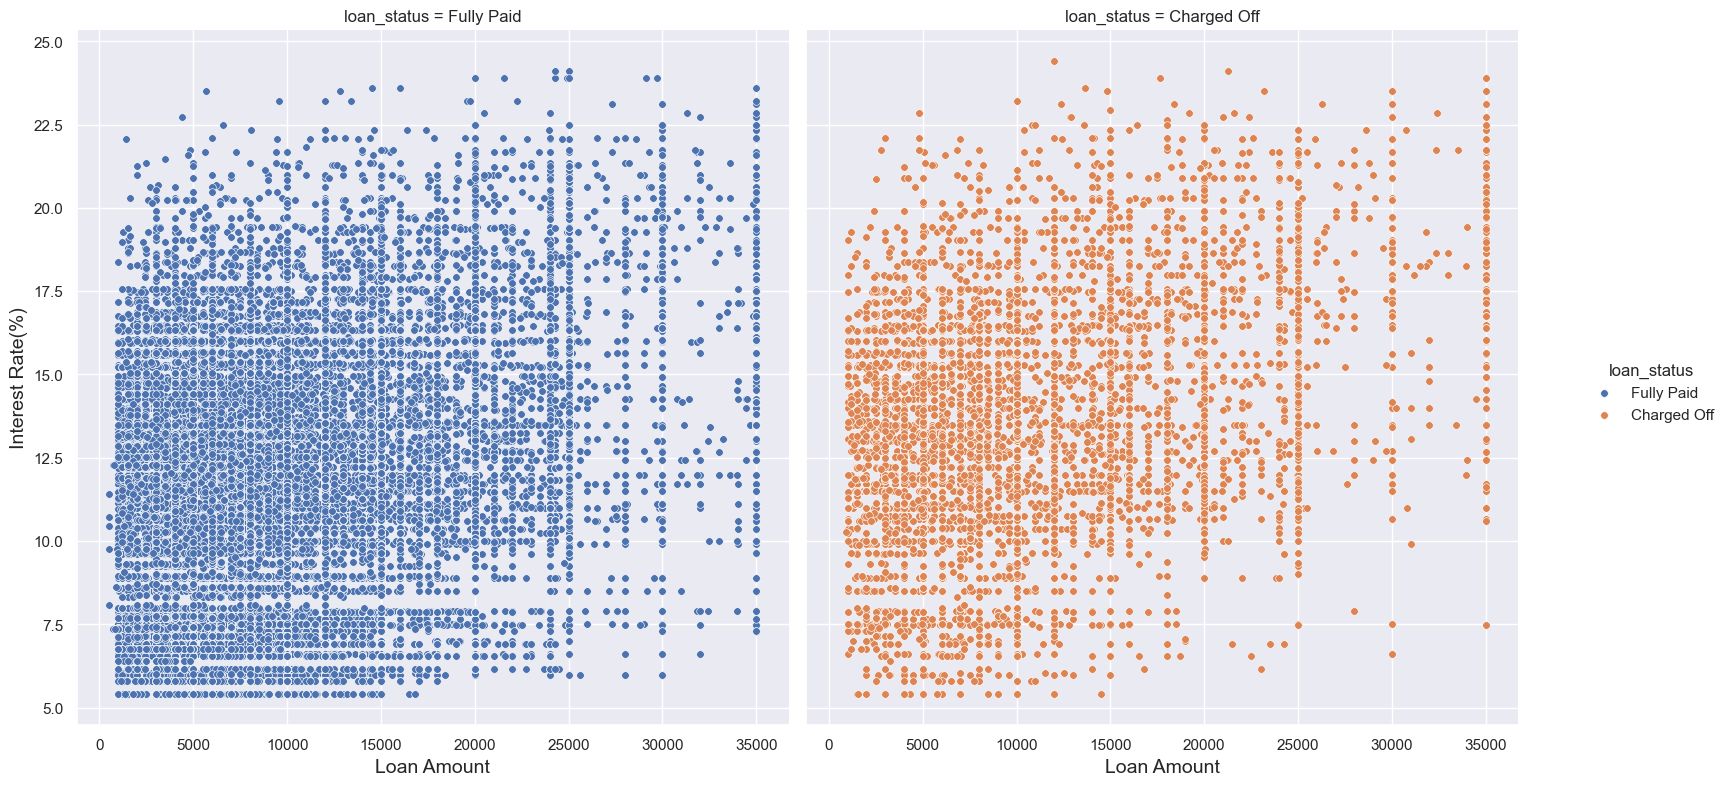

In [1285]:

grid = sns.FacetGrid(loans_df, col="loan_status", hue="loan_status", margin_titles=True, height=8)
grid.map(sns.scatterplot, "loan_amnt", "int_rate", s=30)
grid.set_axis_labels("Loan Amount", "Interest Rate(%)", fontsize=14)

grid.add_legend()
plt.show()


As the scatter plot shows the outliers with 500 > loan_amnt > 32,400 and 5.42 > int_rate > 23.91 are not significant and shouldn't impact the dataset

In [1286]:
# Dropping Outliers
outlier_ir_row = loans_df[(loans_df['int_rate'] > 23.91) | (loans_df['int_rate'] < 5.42)].shape[0]
outlier_la_row = loans_df[(loans_df['loan_amnt'] > 32400) | (loans_df['loan_amnt'] < 500)].shape[0]
print("Dropping {} outlier rows".format((outlier_ir_row + outlier_la_row)))
loans_df = loans_df.drop(loans_df[(loans_df['int_rate'] > 23.91) | (loans_df['int_rate'] < 5.42)].index)
loans_df.reset_index()
loans_df = loans_df.drop(loans_df[(loans_df['loan_amnt'] > 32400) | (loans_df['loan_amnt'] < 500)].index)
loans_df.reset_index()
print("Current shape {}".format(loans_df.shape))

Dropping 662 outlier rows
Current shape (37915, 18)


In [1287]:
defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]
#'whislo','whishi'
box_stats_ir_defaulted_loans = boxplot_stats(defaulted_loans.int_rate).pop(0)
box_stats_ir_completed_loans = boxplot_stats(completedLoans.int_rate).pop(0)
box_stats_la_defaulted_loans = boxplot_stats(defaulted_loans.loan_amnt).pop(0)
box_stats_la_completed_loans = boxplot_stats(completedLoans.loan_amnt).pop(0)

print("Outlier Default Loans InterestRate :  {} < InterestRate < {}".format(box_stats_ir_defaulted_loans['whislo'],
                                                                            box_stats_ir_defaulted_loans['whishi']))
print("Outlier Completed Loans IR :          {} < InterestRate < {}".format(box_stats_ir_completed_loans['whislo'],
                                                                            box_stats_ir_completed_loans['whishi']))
print("Outlier Default Loans Amount :        {} < LoansAmount < {}".format(box_stats_la_defaulted_loans['whislo'],
                                                                           box_stats_la_defaulted_loans['whishi']))
print("Outlier Completed Loans Amount :      {} < LoansAmount < {}".format(box_stats_la_completed_loans['whislo'],
                                                                           box_stats_la_completed_loans['whishi']))

# dropping outliers for loan-amounts > 31500
loans_df = loans_df.drop(loans_df[(loans_df['loan_amnt'] > 31500) | (loans_df['loan_amnt'] < 500)].index)
loans_df.reset_index()
print("Current shape {}".format(loans_df.shape))


Outlier Default Loans InterestRate :  5.42 < InterestRate < 23.91
Outlier Completed Loans IR :          5.42 < InterestRate < 22.11
Outlier Default Loans Amount :        900 < LoansAmount < 31500
Outlier Completed Loans Amount :      500 < LoansAmount < 29375
Current shape (37869, 18)


Total -    Whishhi data > 140000, total outliers: 1741, max outlier: 6000000
Defaulted - Whishhi data > 125000, total outliers: 265, max outlier: 1250000
Completed - Whishhi data > 143500, total outliers: 1499, max outlier: 6000000


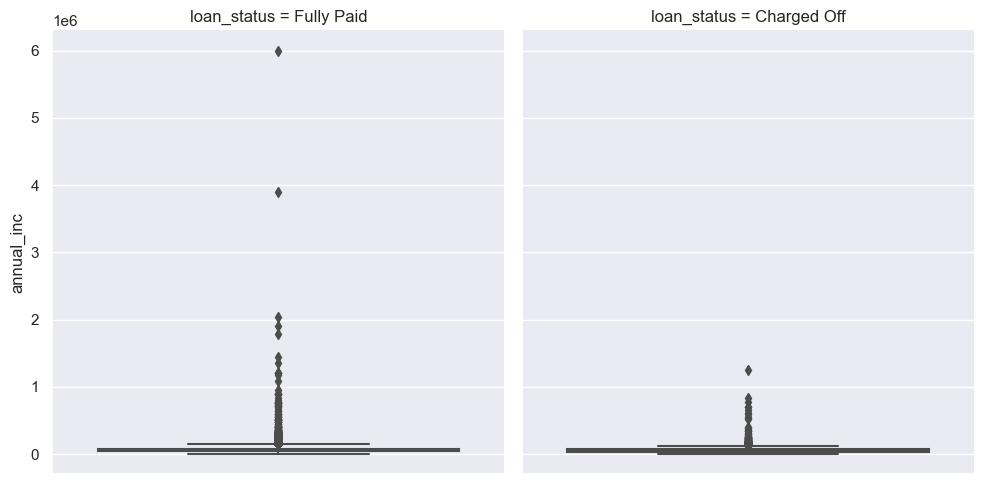

Current shape (37869, 18)
New shape (36128, 18)


In [1288]:
# remove outliners for annual_inc
defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]

box_stats_annual_inc = boxplot_stats(loans_df.annual_inc).pop(0)
#print(box_stats_annual_inc)
print("Total -    Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats_annual_inc['whishi'],
                                                                                 len(box_stats_annual_inc['fliers']),
                                                                                 max(box_stats_annual_inc['fliers'])))

box_stats_annual_inc = boxplot_stats(defaulted_loans.annual_inc).pop(0)

print("Defaulted - Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats_annual_inc['whishi'],
                                                                                  len(box_stats_annual_inc['fliers']),
                                                                                  max(box_stats_annual_inc['fliers'])))

box_stats_annual_inc = boxplot_stats(completedLoans.annual_inc).pop(0)

print("Completed - Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats_annual_inc['whishi'],
                                                                                  len(box_stats_annual_inc['fliers']),
                                                                                  max(box_stats_annual_inc['fliers'])))

sns.catplot(data=loans_df, y="annual_inc", col='loan_status', kind='box');
plt.show()

print("Current shape {}".format(loans_df.shape))
loans_df = loans_df.drop(loans_df[loans_df['annual_inc'] > 140000].index)
loans_df.reset_index()
print("New shape {}".format(loans_df.shape))

For sake of making meaningful data analysis we can remove outliers on the annual income based on the greater of the high whiskers
i.e. drop everything with annual_inc > 140000

Total -    Whishhi data > 130000, total outliers: 465, max outlier: 140000
Current shape (36128, 18)
New shape (35663, 18)


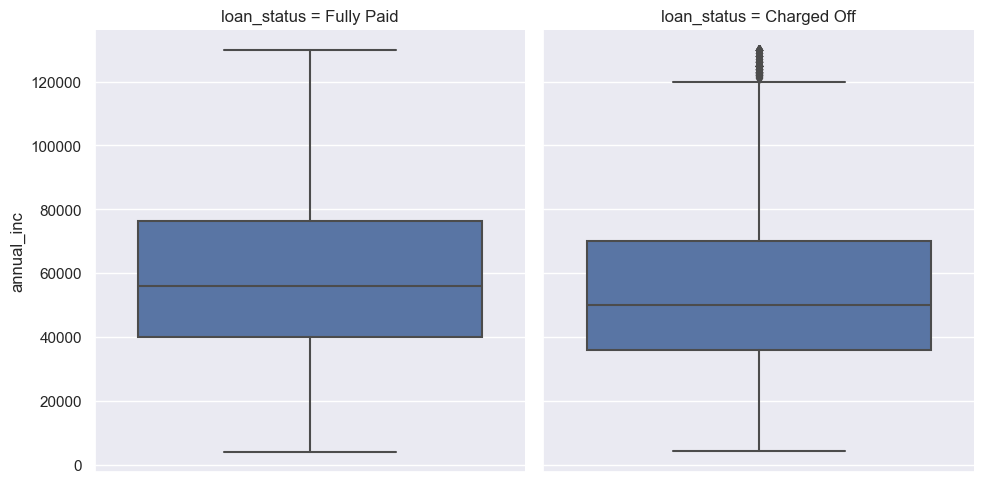

In [1289]:
box_stats_annual_inc = boxplot_stats(loans_df.annual_inc).pop(0)
#print(box_stats_annual_inc)
print("Total -    Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats_annual_inc['whishi'],
                                                                                 len(box_stats_annual_inc['fliers']),
                                                                                 max(box_stats_annual_inc['fliers'])))

print("Current shape {}".format(loans_df.shape))
loans_df = loans_df.drop(loans_df[loans_df['annual_inc'] > 130000].index)
loans_df.reset_index()
print("New shape {}".format(loans_df.shape))

sns.catplot(data=loans_df, y="annual_inc", col='loan_status', kind='box');
plt.show()


Defaulted -    Whishhi data > 30225, total outliers: 9, max outlier: 31500
Completed -    Whishhi data > 27500, total outliers: 346, max outlier: 31300
Current shape (35663, 18)
New shape (35639, 18)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


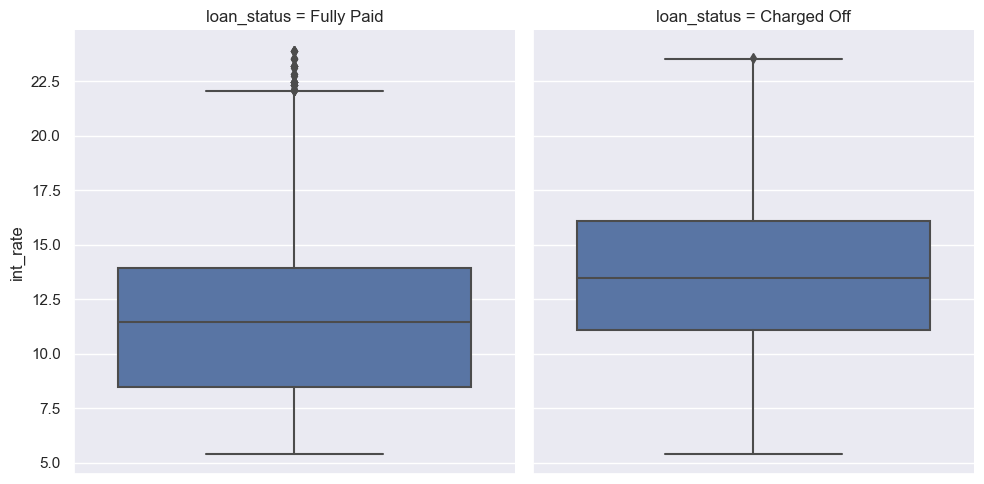

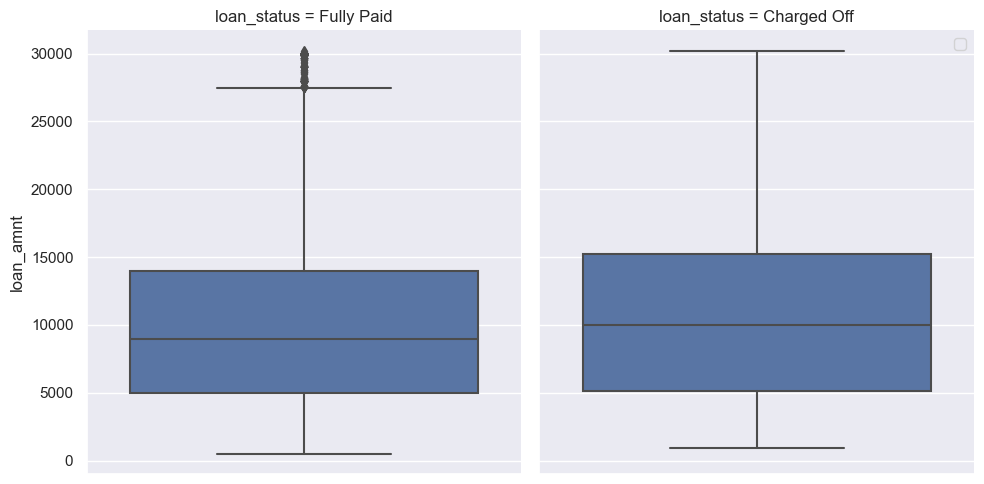

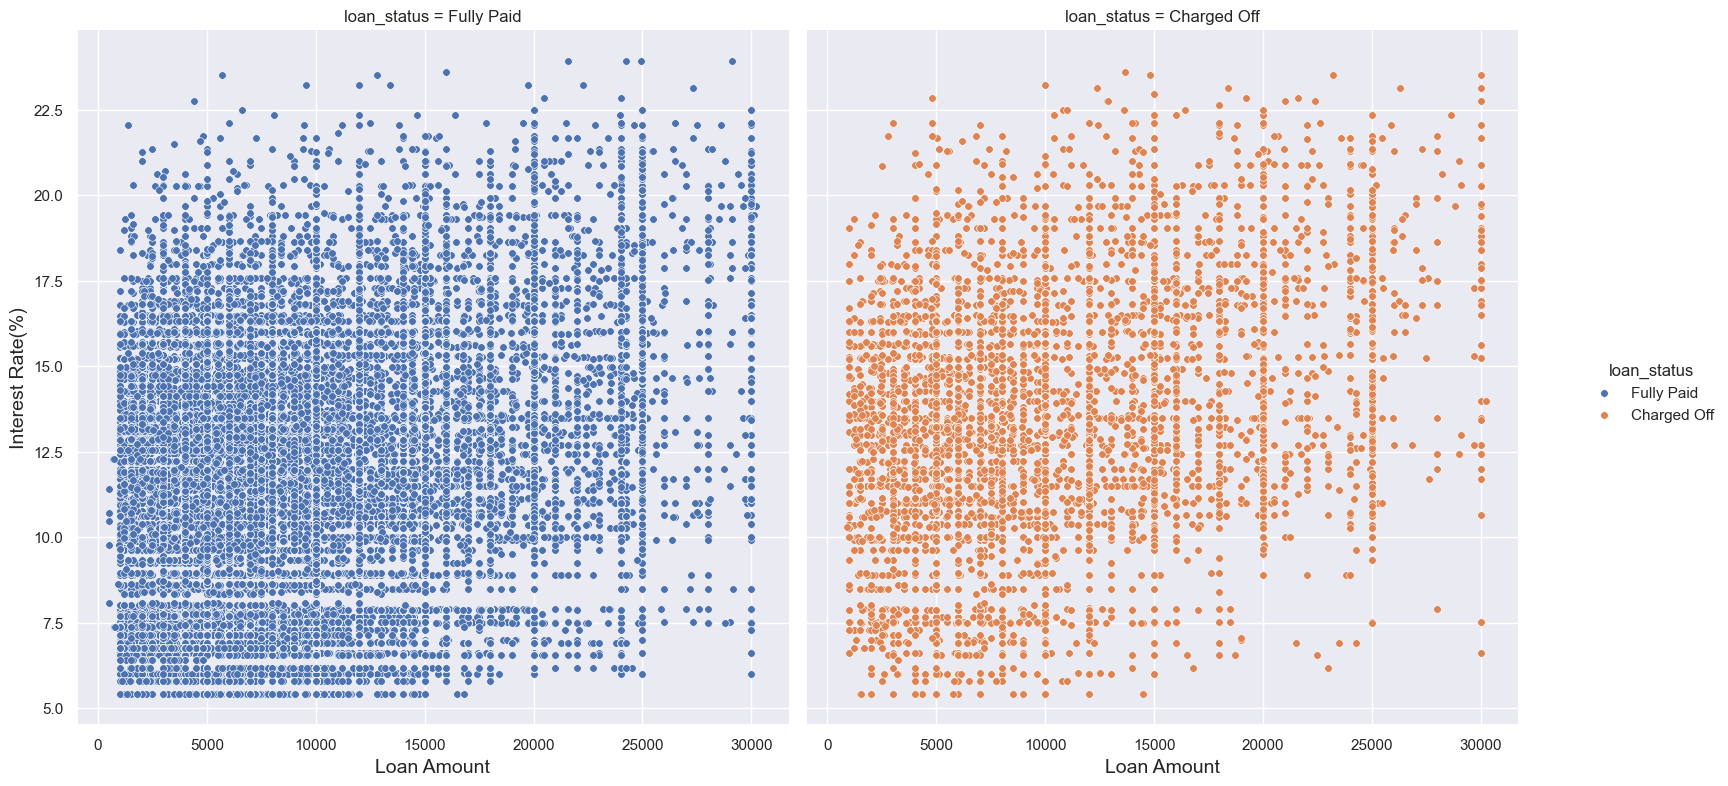

In [1290]:
# checking if any new outliers
defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]

box_stats = boxplot_stats(defaulted_loans.loan_amnt).pop(0)
#print(box_stats_annual_inc)
print("Defaulted -    Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats['whishi'],
                                                                                     len(box_stats['fliers']),
                                                                                     max(box_stats['fliers'])))

box_stats = boxplot_stats(completedLoans.loan_amnt).pop(0)
#print(box_stats_annual_inc)
print("Completed -    Whishhi data > {}, total outliers: {}, max outlier: {}".format(box_stats['whishi'],
                                                                                     len(box_stats['fliers']),
                                                                                     max(box_stats['fliers'])))

print("Current shape {}".format(loans_df.shape))
loans_df = loans_df.drop(loans_df[loans_df['loan_amnt'] > 30225].index)
loans_df.reset_index()
print("New shape {}".format(loans_df.shape))

sns.catplot(data=loans_df, y="int_rate", col='loan_status', hue='loan_status', kind='box');
sns.catplot(data=loans_df, y="loan_amnt", col='loan_status', hue='loan_status', kind='box');
plt.legend()
grid = sns.FacetGrid(loans_df, col="loan_status", hue="loan_status", margin_titles=True, height=8)
grid.map(sns.scatterplot, "loan_amnt", "int_rate", s=30)
grid.set_axis_labels("Loan Amount", "Interest Rate(%)", fontsize=14)

grid.add_legend()
plt.show()



### Bivariate Analysis On Continuous Variables

Use Correlation to identify relationship between continuous variables
- r   < 0.3, _weak correlation_
- 0.3 < r < 0.7, _moderate correlation_
- r   > 0.7, _high correlation_


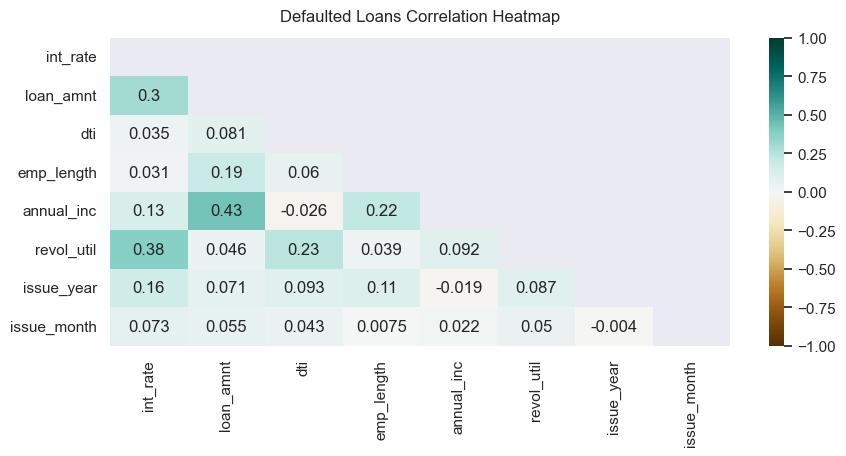

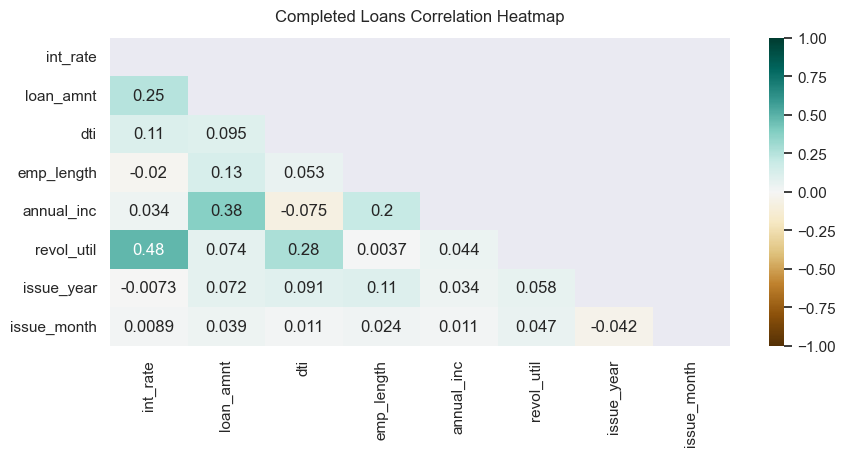

In [1291]:
defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
defaulted_loans_cont = defaulted_loans[['int_rate', 'loan_amnt', 'dti','emp_length', 'annual_inc', 'revol_util', 'issue_year', 'issue_month']]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]
completedLoans_cont = completedLoans[['int_rate', 'loan_amnt', 'dti','emp_length', 'annual_inc', 'revol_util', 'issue_year', 'issue_month']]

# Correlation on defaulted loans
plt.figure(figsize=(10, 4))
mask = np.triu(np.ones_like(defaulted_loans_cont.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(defaulted_loans_cont.corr(method='pearson'),mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Defaulted Loans Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

# Correlation on completed loans
plt.figure(figsize=(10, 4))
mask = np.triu(np.ones_like(completedLoans_cont.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(completedLoans_cont.corr(method='pearson'),mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Completed Loans Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()


Continuous variables with moderate to high correlation

**Defaulted Dataset**
- loan_amnt - int_rate : 0.3 (moderate)
- revol_util - int_rate: 0.38 (moderate)
- annual_inc - loan_amount: 0.43 (moderate)

**Completed Dataset**
- revol_util - int_rate: 0.48 (moderate)
- annual_inc - loan_amount: 0.38(moderate)

It appears the `loan_amnt - int_rate` has a moderate +-ive correlation seen in the defaulted dataset
There is also a higher correlation between `annual_inc - loan_amount` in the defaulted dataset
There is also a higher correlation between  `revol_util - int_rate` in the completed dataset as opposed to the defaulted dataset

### Univariate Analysis on Continuous Variables

Analyse the columns picked up in the correlation matrix for frequency distribution
- Loan Amount
- Loan Interest Rate
- Annual Income


In [1292]:
defaulted_loans = loans_df[loans_df['loan_status_cat'] == 0]
completedLoans = loans_df[loans_df['loan_status_cat'] == 1]


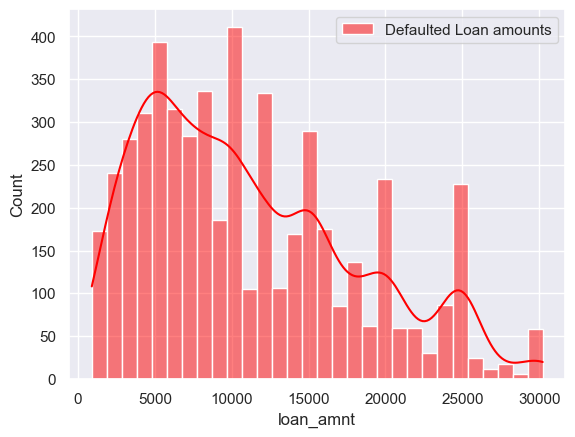

In [1293]:
sns.histplot(data=defaulted_loans, x='loan_amnt', bins=30,  color="red", label="Defaulted Loan amounts", kde=True)
plt.legend()
plt.show()


_The defaulted loans seem to be more prevelant to the first 10,000 but also large spikes are seen every 5000 increment_
Suggest to break down the loan amount into buckets of 5000
0-5000      - XS
5000-10000  - S
10000-15000 - M
15000-20000 - L
20000-25000 - XL
25000-31000 - XXL

In [1294]:
def mapLoanAmountBucket(x):
    if x < 5000:
        return 'XS-Amount'
    elif 5000 <= x < 10000:
        return 'S-Amount'
    elif 10000 <= x < 15000:
        return 'M-Amount'
    elif 15000 <= x < 20000:
        return 'L-Amount'
    elif 20000 <= x < 25000:
        return 'XL-Amount'
    else:
        return 'XXL-Amount'
defaulted_loans['loan_amnt_bucket'] = defaulted_loans.loan_amnt.apply(lambda x: mapLoanAmountBucket(x))
completedLoans['loan_amnt_bucket'] = completedLoans.loan_amnt.apply(lambda x: mapLoanAmountBucket(x))

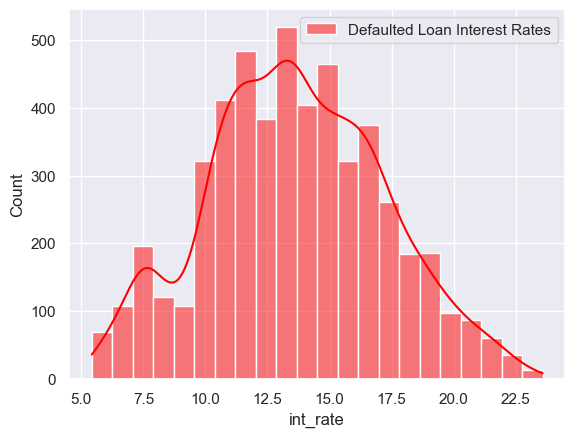

In [1295]:
sns.histplot(data=defaulted_loans, x='int_rate', bins=22, color="red", label="Defaulted Loan Interest Rates", kde=True)

plt.legend()
plt.show()


Interest rate defaults maximum seems to occur between 10 - 20% buckets
Suggest to break down if Interest rates into buckets
0  - 10    - M-IR
10 - 20    - L-IR   (Hi default)
20 - 30    - XL-IR

In [1296]:
def mapIRBucket(x):
    if x < 10:
        return 'M-IR'
    elif 10 <= x < 20:
        return 'L-IR'
    else:
        return 'XL-IR'
defaulted_loans['int_rate_bucket'] = defaulted_loans.int_rate.apply(lambda x: mapIRBucket(x))
completedLoans['int_rate_bucket'] = completedLoans.int_rate.apply(lambda x: mapIRBucket(x))


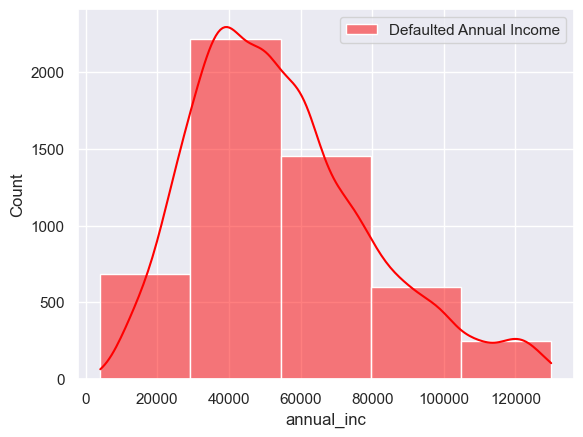

In [1297]:
sns.histplot(data=defaulted_loans, x='annual_inc', bins=5, color="red", label="Defaulted Annual Income", kde=True)
plt.legend()
plt.show()


_Maximum defaults seem to happen for income that are between 40,000 to 80,000_
0     - 26000   - S-Inc
26000 - 52000   - M-Inc (high)
52000 - 78000   - L-Inc (high)
78000 - 104000  - XL-Inc
104000 - 130000 - XXL-Inc

In [1298]:
def mapIncome(x):
    if x < 26000:
        return 'S-Inc'
    elif 26000 <= x < 52000:
        return 'M-Inc'
    elif 52000 <= x < 78000:
        return 'L-Inc'
    elif 78000 <= x < 104000:
        return 'XL-Inc'
    else:
        return 'XXL-Inc'

defaulted_loans['annual_inc_bucket'] = defaulted_loans.annual_inc.apply(lambda x: mapIncome(x))
completedLoans['annual_inc_bucket'] = completedLoans.annual_inc.apply(lambda x: mapIncome(x))


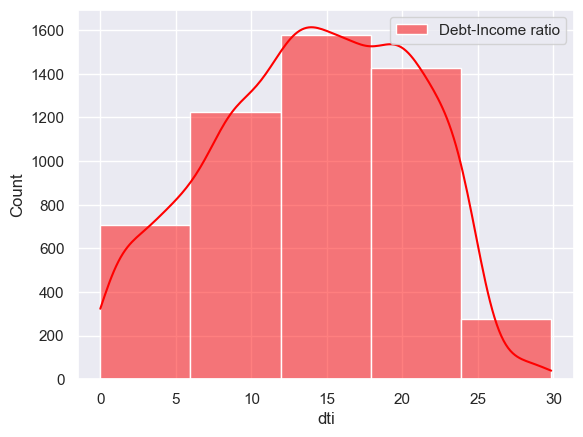

In [1299]:
sns.histplot(data=defaulted_loans, x='dti', bins=5, color="red", label="Debt-Income ratio", kde=True)
plt.legend()
plt.show()


In [1300]:
def mapDTIBucket(x):
    if x < 5:
        return 'XS-DTI'
    elif 5 <= x < 10:
        return 'S-DTI'
    elif 10 <= x < 15:
        return 'M-DTI'
    elif 15 <= x < 20:
        return 'L-DTI'
    elif 20 <= x < 25:
        return 'XL-DTI'
    else:
        return 'XXL-DTI'
defaulted_loans['dti_bucket'] = defaulted_loans.dti.apply(lambda x: mapDTIBucket(x))
completedLoans['dti_bucket'] = completedLoans.dti.apply(lambda x: mapDTIBucket(x))


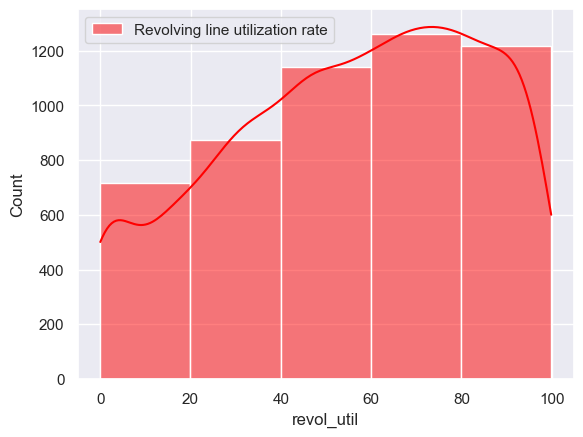

In [1301]:
sns.histplot(data=defaulted_loans, x='revol_util', bins=5, color="red", label="Revolving line utilization rate", kde=True)
plt.legend()
plt.show()


In [1302]:
def mapRevolUtilBucket(x):
    if x < 20.0:
        return 'XS-revo_util'
    elif 20.0 <= x < 40.0:
        return 'S-revo_util'
    elif 40.0 <= x < 60.0:
        return 'M-revo_util'
    elif 60.0 <= x < 80.0:
        return 'L-revo_util'
    elif 80.0 <= x <= 100.0:
        return 'XL-revo_util'

defaulted_loans['revol_util_bucket'] = defaulted_loans.revol_util.apply(lambda x: mapRevolUtilBucket(x))
completedLoans['revol_util_bucket'] = completedLoans.revol_util.apply(lambda x: mapRevolUtilBucket(x))

In [1303]:
defaulted_loans.columns

Index(['int_rate', 'loan_amnt', 'issue_d', 'loan_status',
       'verification_status', 'term', 'grade', 'sub_grade', 'dti',
       'emp_length', 'purpose', 'annual_inc', 'revol_util', 'addr_state',
       'home_ownership', 'issue_year', 'issue_month', 'loan_status_cat',
       'loan_amnt_bucket', 'int_rate_bucket', 'annual_inc_bucket',
       'dti_bucket', 'revol_util_bucket'],
      dtype='object')

In [1304]:
completedLoans.columns

Index(['int_rate', 'loan_amnt', 'issue_d', 'loan_status',
       'verification_status', 'term', 'grade', 'sub_grade', 'dti',
       'emp_length', 'purpose', 'annual_inc', 'revol_util', 'addr_state',
       'home_ownership', 'issue_year', 'issue_month', 'loan_status_cat',
       'loan_amnt_bucket', 'int_rate_bucket', 'annual_inc_bucket',
       'dti_bucket', 'revol_util_bucket'],
      dtype='object')

### Bivariate Analysis

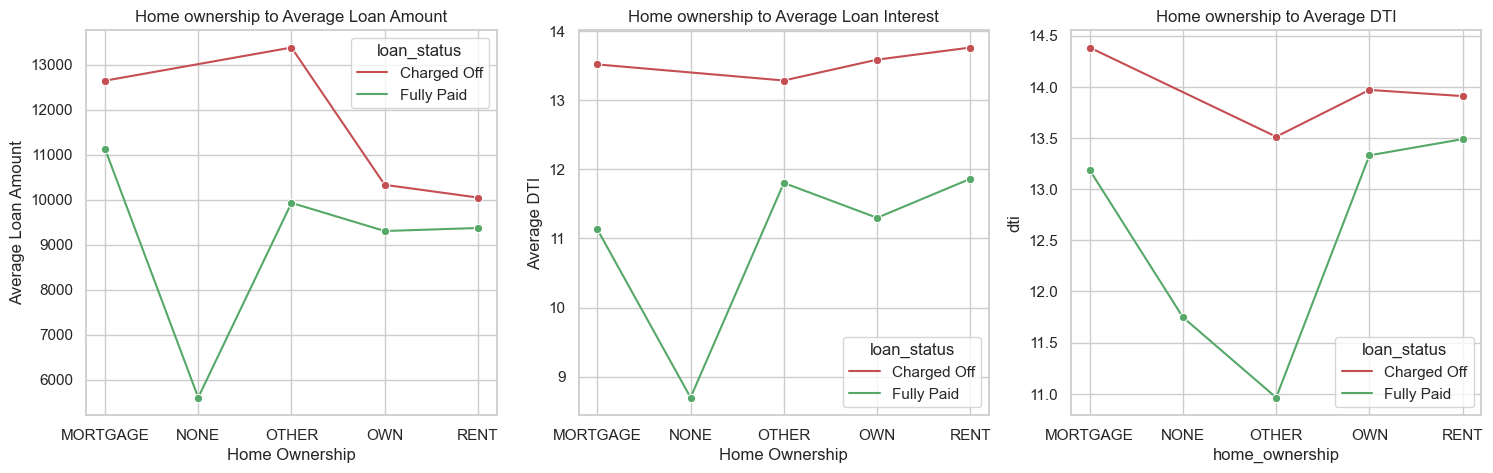

In [1305]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18,5))
df = loans_df.groupby(['home_ownership','loan_status'])['loan_amnt','int_rate','dti'].mean().reset_index()

sns.lineplot(x=df.home_ownership,y=df.loan_amnt,hue=df.loan_status, ax=axes[0],marker="o", data=df,palette=['r', 'g'])
axes[0].set_title('Home ownership to Average Loan Amount')

sns.lineplot(x=df.home_ownership,y=df.int_rate,hue=df.loan_status, ax=axes[1],marker="o", data=df,palette=['r', 'g'])
axes[1].set_title('Home ownership to Average Loan Interest')

sns.lineplot(x=df.home_ownership,y=df.dti,hue=df.loan_status, ax=axes[2],marker="o", data=df,palette=['r', 'g'])
axes[2].set_title('Home ownership to Average DTI')

axes[0].set(xlabel="Home Ownership",ylabel="Average Loan Amount")
axes[1].set(xlabel="Home Ownership",ylabel="Average Interest Rate")
axes[1].set(xlabel="Home Ownership",ylabel="Average DTI")
plt.show()



**Home Ownership**
- Defaulted Users have higher average Loan Amount and Interest Rate across all the types home-owners
- The high interest rate seem to tally with the high average DTI seen across home-owners


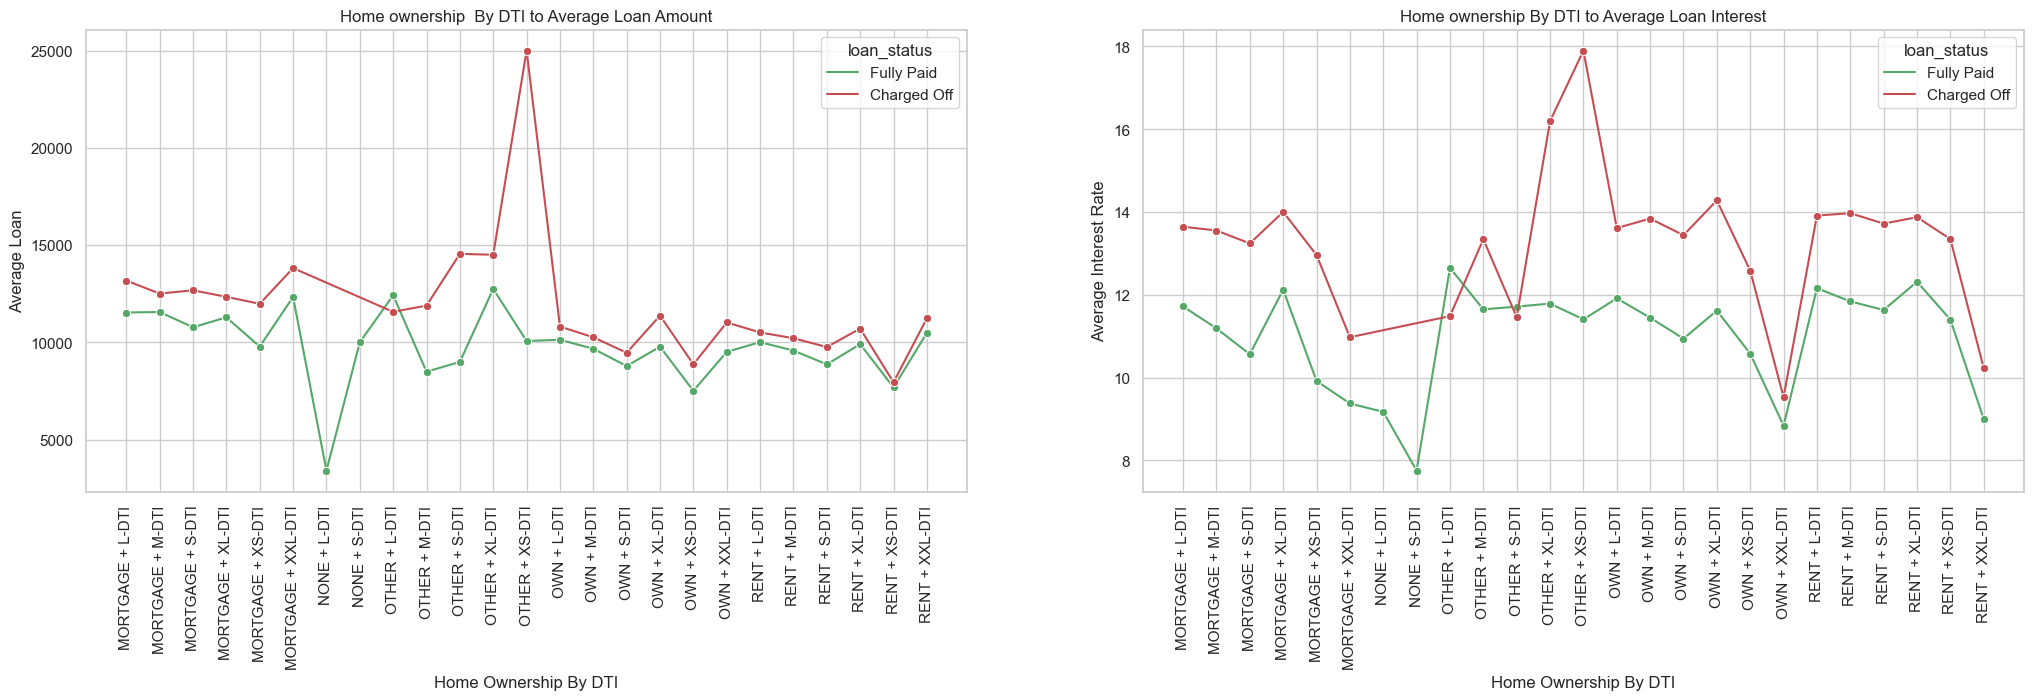

In [1306]:
def_df = defaulted_loans.groupby(['home_ownership','dti_bucket'])['int_rate','loan_amnt'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['home_ownership','dti_bucket'])['int_rate','loan_amnt'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()
df['home_ownership-dti_bucket'] = df['home_ownership']+" + " + df['dti_bucket']

sns.set(style = 'whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(25,6))
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)

sns.lineplot(x='home_ownership-dti_bucket',y=df.loan_amnt,hue=df.loan_status, ax=axes[0],marker="o", data=df, palette=['g', 'r'])
axes[0].set_title('Home ownership  By DTI to Average Loan Amount')

sns.lineplot(x='home_ownership-dti_bucket',y=df.int_rate,hue=df.loan_status, ax=axes[1],marker="o",  data=df, palette=['g', 'r'])
axes[1].set_title('Home ownership By DTI to Average Loan Interest')

axes[0].set(xlabel="Home Ownership By DTI",ylabel="Average Loan")
axes[1].set(xlabel="Home Ownership By DTI",ylabel="Average Interest Rate")


plt.show()



**Home Ownership by DTI**
- The Average Loan Amount or interest rate seems to not be significantly different across the various buckets of DTI to the home-ownership
- The only deviation seems to be for customers high average loans in the following bucket:
  - OTHER - XS-DTI (dti < 5.0) where average loan amount was close to 25,000
  - OTHER - XS-DTI also had th highest interest rate 18% which could be the main reason

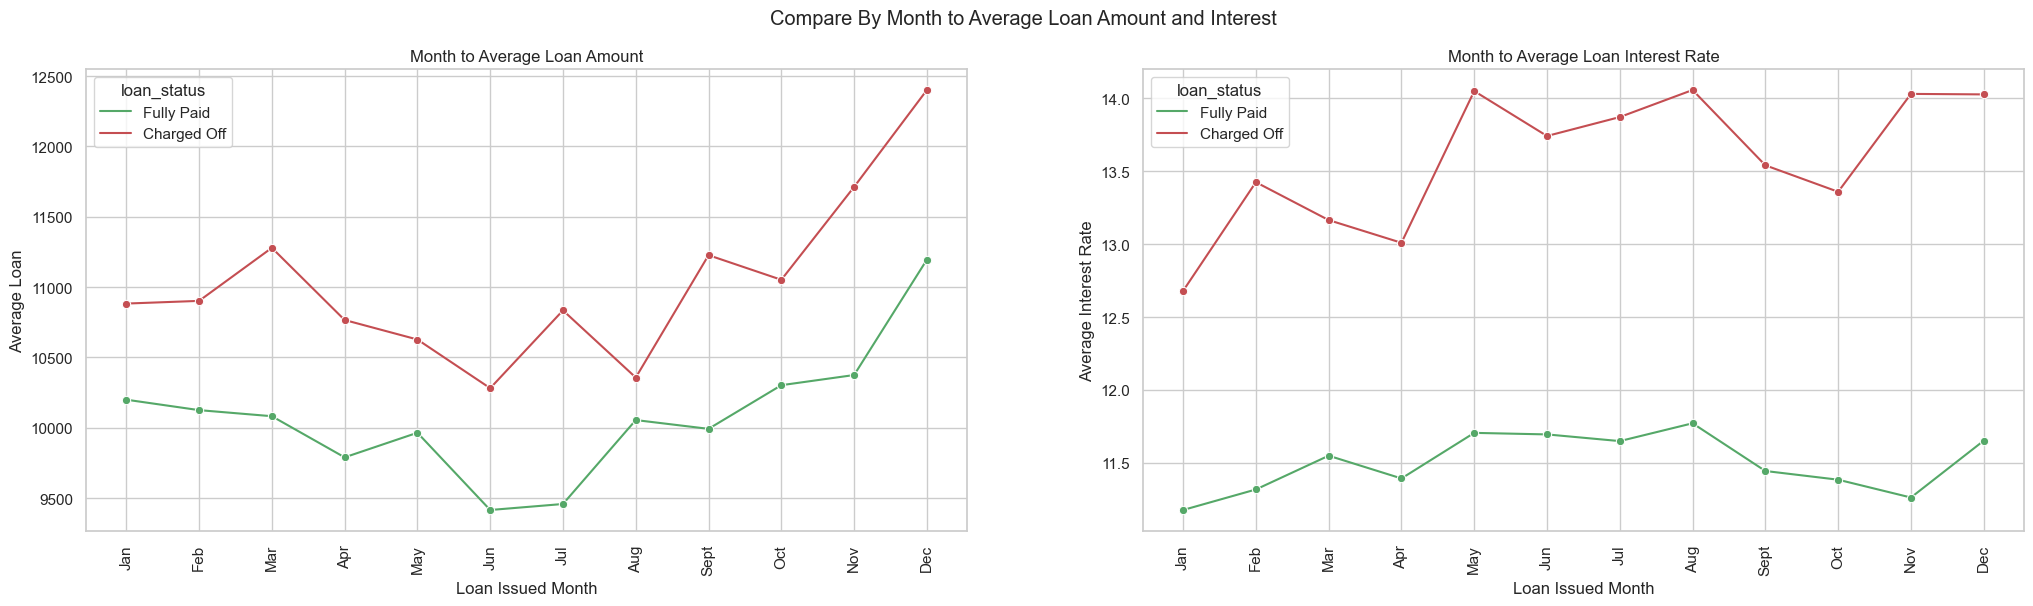

In [1307]:
def_df = defaulted_loans.groupby(['issue_month'])['loan_amnt','int_rate'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['issue_month'])['loan_amnt','int_rate'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(25,6))
fig.suptitle('Compare By Month to Average Loan Amount and Interest')
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks([i for i in range(1,13)], ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
    plt.xticks(rotation = 90)

sns.lineplot(x=df.issue_month,y=df.loan_amnt,hue=df.loan_status, data=df,marker="o", ax=axes[0], palette=['g', 'r'])
axes[0].set_title('Month to Average Loan Amount')

sns.lineplot(x=df.issue_month,y=df.int_rate,hue=df.loan_status, data=df,marker="o", ax=axes[1], palette=['g', 'r'])
axes[1].set_title('Month to Average Loan Interest Rate')


axes[0].set(xlabel="Loan Issued Month",ylabel="Average Loan")
axes[1].set(xlabel="Loan Issued Month",ylabel="Average Interest Rate")


plt.show()

**Loans By Month**
- The average of the loan amounts and the interest rate seems to increase and especially towards the year-end
- And defaults happen for those interest rates that are above 12% on average monthly
- Would be advisable to keep the interest low

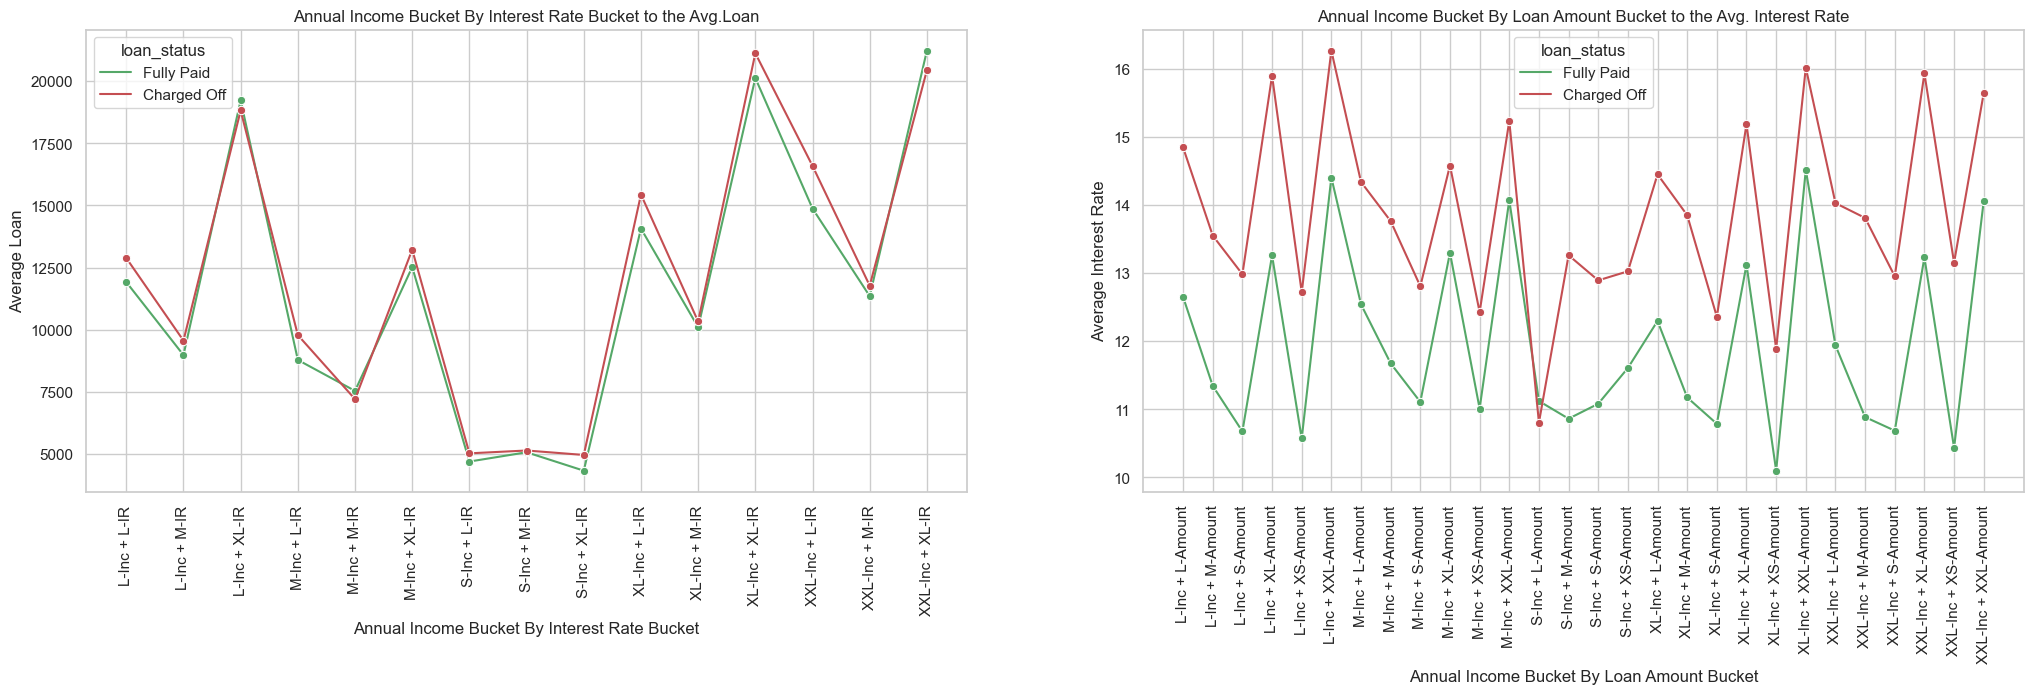

In [1308]:
def_df = defaulted_loans.groupby(['annual_inc_bucket','loan_amnt_bucket'])['int_rate'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['annual_inc_bucket','loan_amnt_bucket'])['int_rate'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()
df['annual_inc_bucket-loan_amnt_bucket'] = df['annual_inc_bucket'] + " + " +  df['loan_amnt_bucket']

def_df = defaulted_loans.groupby(['annual_inc_bucket','int_rate_bucket'])['loan_amnt'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['annual_inc_bucket','int_rate_bucket'])['loan_amnt'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df1 = com_df.append(def_df, ignore_index=True).reset_index()
df1['annual_inc_bucket-int_rate_bucket'] = df1['annual_inc_bucket'] + " + " +  df1['int_rate_bucket']


sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(25,6))
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)

sns.lineplot(x='annual_inc_bucket-int_rate_bucket',y=df1.loan_amnt,hue=df1.loan_status, data=df1,marker="o", ax=axes[0], palette=['g', 'r'])
axes[0].set_title('Annual Income Bucket By Interest Rate Bucket to the Avg.Loan')

sns.lineplot(x='annual_inc_bucket-loan_amnt_bucket',y=df.int_rate,hue=df.loan_status, data=df,marker="o", ax=axes[1], palette=['g', 'r'])
axes[1].set_title('Annual Income Bucket By Loan Amount Bucket to the Avg. Interest Rate')

axes[0].set(xlabel="Annual Income Bucket By Interest Rate Bucket",ylabel="Average Loan")
axes[1].set(xlabel="Annual Income Bucket By Loan Amount Bucket",ylabel="Average Interest Rate")


plt.show()



**Annual Income**
- Annual Income bucket coupled with interest rates buckets seem to have similar average loans amounts for defaulted and completed loans
  - This could indicate the loan amount as such doesn't contribute to the defaulting
- However, when we do the same for interest rate buckets we see that the defaulted loans have higher average interest rates
  - An exception is found at the data-point S-Inc (0-26,000 income) + L-Amount (15,000 - 20,000 Loan) where the interest rate is also low (< 11%)

_This could mean that interest rates primarily contribute the loan defaulting_

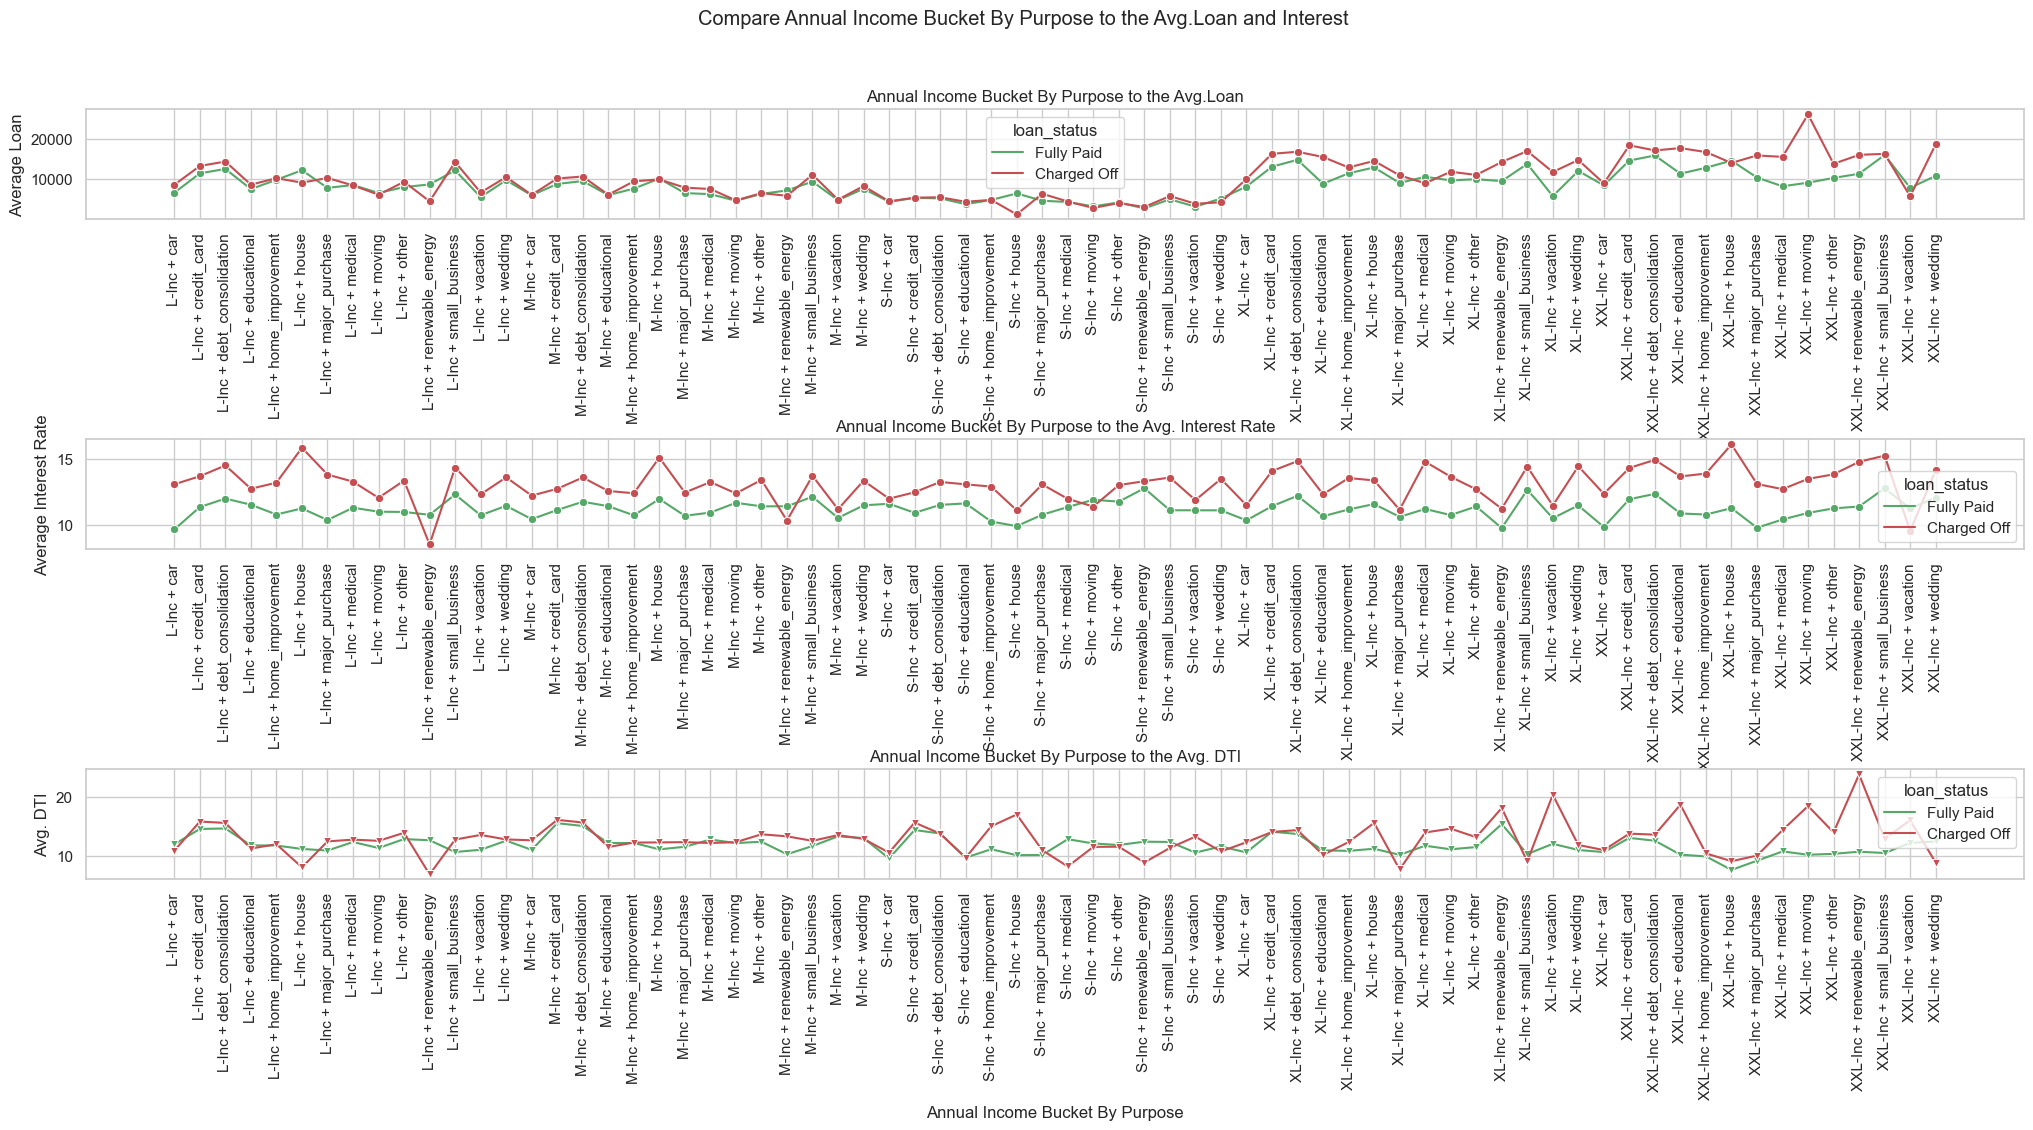

In [1309]:
def_df = defaulted_loans.groupby(['annual_inc_bucket','purpose'])['loan_amnt','int_rate','dti'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['annual_inc_bucket','purpose'])['loan_amnt','int_rate','dti'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()
df['annual_inc_bucket-purpose'] = df['annual_inc_bucket'] + " + " +  df['purpose']

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(25,10))
fig.suptitle('Compare Annual Income Bucket By Purpose to the Avg.Loan and Interest')

plt.subplots_adjust(hspace = 2)

for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)

sns.lineplot(x='annual_inc_bucket-purpose',y=df.loan_amnt,hue=df.loan_status, data=df,marker="o", ax=axes[0], palette=['g', 'r'])
axes[0].set_title('Annual Income Bucket By Purpose to the Avg.Loan')

sns.lineplot(x='annual_inc_bucket-purpose',y=df.int_rate,hue=df.loan_status, data=df,marker="o", ax=axes[1], palette=['g', 'r'])
axes[1].set_title('Annual Income Bucket By Purpose to the Avg. Interest Rate')

sns.lineplot(x='annual_inc_bucket-purpose',y=df.dti,hue=df.loan_status, data=df,marker="v", ax=axes[2], palette=['g', 'r'])
axes[2].set_title('Annual Income Bucket By Purpose to the Avg. DTI')

axes[0].set(xlabel="Annual Income Bucket By Purpose",ylabel="Average Loan")
axes[1].set(xlabel="Annual Income Bucket By Purpose",ylabel="Average Interest Rate")
axes[2].set(xlabel="Annual Income Bucket By Purpose",ylabel="Avg. DTI")

plt.show()


**Loan Purpose**
- The average loan amount for the reason in taking a loan bucketed by the Income is similar for defaulted and completed loans except for:
  - XXL-Inc(104K - 130K) + major purchase
  - XXL-Inc(104K - 130K) + medical
  - XXL-Inc(104K - 130K) + moving
  - XXL-Inc(104K - 130K) + home improvement
  - XXL-Inc(104K - 130K) + educational
- The average interest rate for the reason in taking a loan bucketed by the Income is much higher in the defaulted loans as compared to completed loans
- Specifically for the above the interest rates have been
  - XXL-Inc(104K - 130K) + major purchase > 12%
  - XXL-Inc(104K - 130K) + medical - > 12 %
  - XXL-Inc(104K - 130K) + moving - > 12%
  - XXL-Inc(104K - 130K) + home improvement - > 14%
  - XXL-Inc(104K - 130K) + educational - > 13%
  - L-Inc - debt_consolidation > 14%
  - L -Inc - House > 16%
- The average DTI for above sectors are also mostly greater than 10:
  - XXL-Inc(104K - 130K) + major purchase > 15
  - XXL-Inc(104K - 130K) + medical - = 15
  - XXL-Inc(104K - 130K) + moving - > 15
  - XXL-Inc(104K - 130K) + home improvement - > 10
  - XXL-Inc(104K - 130K) + educational - > 15
  - L-Inc - debt_consolidation > 15
  - L -Inc - House < 10

_This could ean large projects tend to be more riskier even if the annual income of the person is large but also carry a lot of debt_

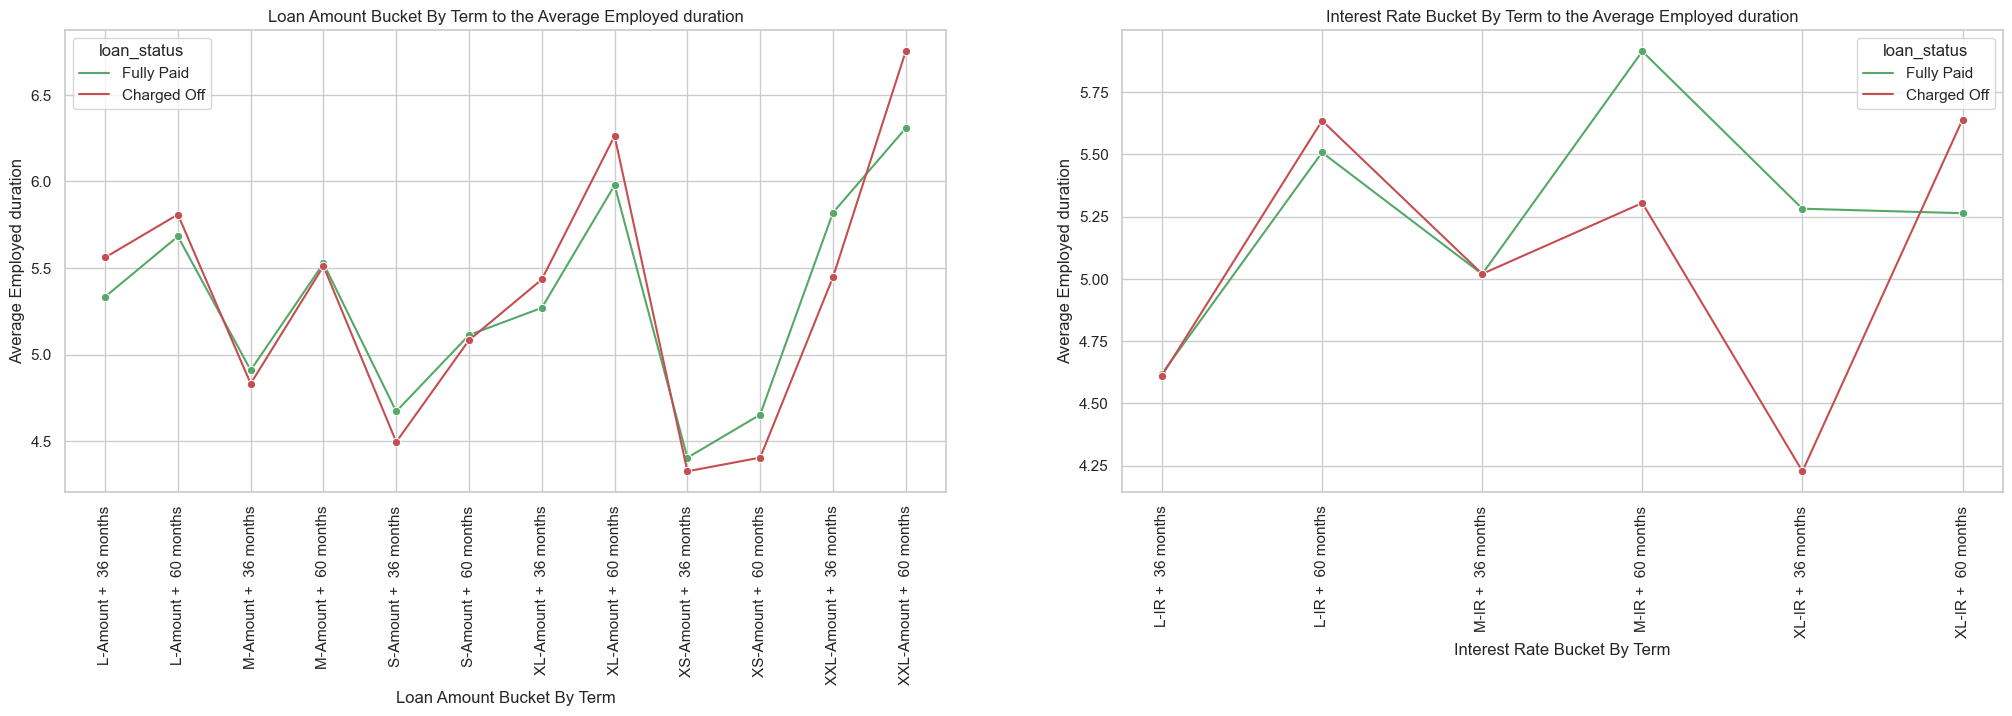

In [1310]:
def_df = defaulted_loans.groupby(['loan_amnt_bucket','term'])['emp_length'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['loan_amnt_bucket','term'])['emp_length'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()
df['loan_amnt_bucket-term'] = df['loan_amnt_bucket'] + " + " +  df['term']

def_df = defaulted_loans.groupby(['int_rate_bucket','term'])['emp_length'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['int_rate_bucket','term'])['emp_length'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df1 = com_df.append(def_df, ignore_index=True).reset_index()
df1['int_rate_bucket-term'] = df1['int_rate_bucket'] + " + " +  df1['term']

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(25,6))
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)

sns.lineplot(x='loan_amnt_bucket-term',y=df.emp_length,hue=df.loan_status, data=df,marker="o", ax=axes[0],palette=['g', 'r'])
sns.lineplot(x='int_rate_bucket-term',y=df1.emp_length,hue=df1.loan_status, data=df1,marker="o", ax=axes[1], palette=['g', 'r'])

axes[0].set_title('Loan Amount Bucket By Term to the Average Employed duration')
axes[1].set_title('Interest Rate Bucket By Term to the Average Employed duration')
axes[0].set(xlabel="Loan Amount Bucket By Term",ylabel="Average Employed duration")
axes[1].set(xlabel="Interest Rate Bucket By Term",ylabel="Average Employed duration")

plt.show()



**Employed Duration**
- The average employed duration of the customer has no bearing when taken against buckets of Loan amount by Loan term
- There does show a difference when done against buckets of interest rate by Loan term
    - M-IR (< 10 %) for 60-Month term defaults at lower employed duration (avg. 5.25 - 5.5 )
    - XL-IR (20-30%) for 36 months terms defaults at lower employed duration (avg. 4.25)
    - XL-IR (20-30%) for 60 months terms defaults at higher employed duration (avg. 5.5-5.75)

_This might mean that longer terms might have stronger chance to leading to successful loans_

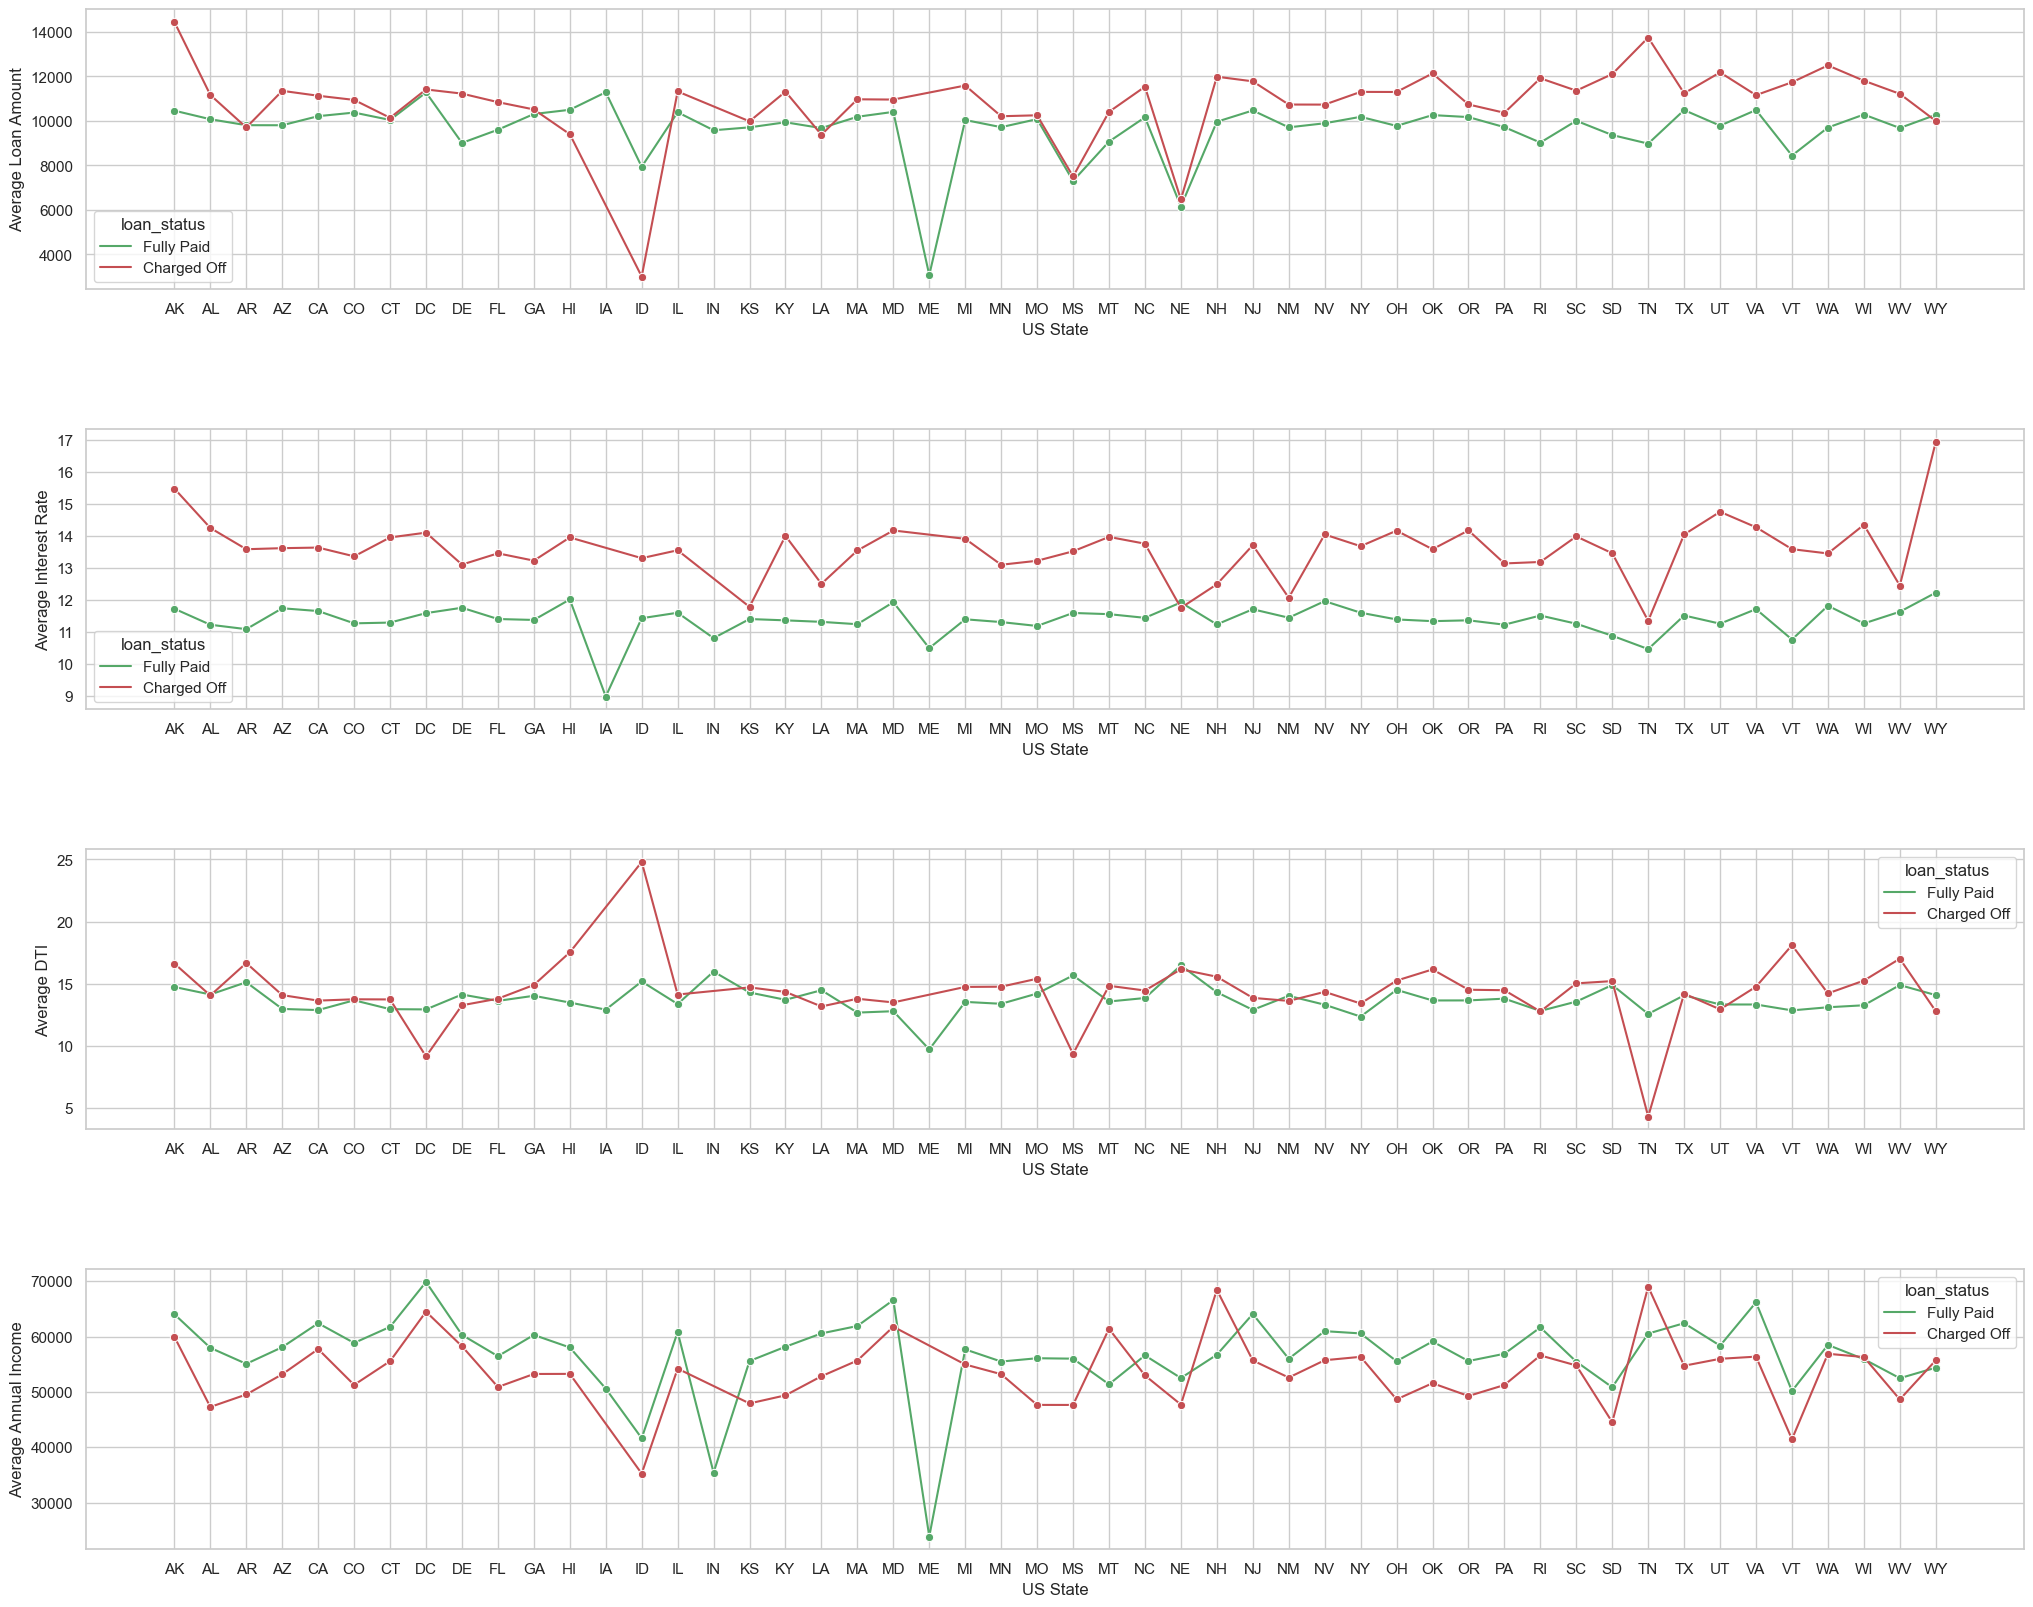

In [1311]:
def_df = defaulted_loans.groupby(['addr_state'])['loan_amnt','int_rate','dti','annual_inc'].mean().reset_index()
def_df['loan_status'] = 'Charged Off'
com_df = completedLoans.groupby(['addr_state'])['loan_amnt','int_rate','dti','annual_inc'].mean().reset_index()
com_df['loan_status'] = 'Fully Paid'
df = com_df.append(def_df, ignore_index=True).reset_index()

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(4, 1, figsize=(25,20))
plt.subplots_adjust(hspace = 0.5)


for ax in axes.flatten():
    plt.sca(ax)


sns.lineplot(x='addr_state',y=df.loan_amnt,hue=df.loan_status, data=df,marker="o", ax=axes[0], palette=['g', 'r'])
sns.lineplot(x='addr_state',y=df.int_rate,hue=df.loan_status, data=df,marker="o", ax=axes[1], palette=['g', 'r'])
sns.lineplot(x='addr_state',y=df.dti,hue=df.loan_status, data=df,marker="o", ax=axes[2], palette=['g', 'r'])
sns.lineplot(x='addr_state',y=df.annual_inc,hue=df.loan_status, data=df,marker="o", ax=axes[3], palette=['g', 'r'])

axes[0].set(xlabel="US State",ylabel="Average Loan Amount")
axes[1].set(xlabel="US State",ylabel="Average Interest Rate")
axes[2].set(xlabel="US State",ylabel="Average DTI")
axes[3].set(xlabel="US State",ylabel="Average Annual Income")

plt.show()



**States**
- All defaulted loans have interest rates roughly >= 14%
- ID has the highest average DTI for defaulted loans and hence defaults happen for lower loan amount as compared to other states
- TN has the lowest DTI for defaulted loans < 5 and they tend to have the same average interest rates for defaulted and completed loans
- The average income across states is generally higher for the completed loans as opposed to the defaulted loans

In General
- High Income states with low DTI can get lower interest rates
- Low income states with high DTI should get higher interest rates for their loans